In [25]:
#importing libraries
import numpy as np
import cv2
import os
import pandas as pd
from PIL import Image
import tensorflow.keras
import tensorflow as tf
np.random.seed(1000)
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix,f1_score,classification_report

In [26]:
data_dir = "all_canny/"
test_dir = 'canny_test/'
train_dir = os.path.join(data_dir)
test_dir = os.path.join(test_dir)
print(train_dir)
print(test_dir)

all_canny/
canny_test/


In [27]:
labels = []
for directory in os.listdir(train_dir):
    labels.append(directory)
print(labels)
print(str(len(labels)) + " classes")


['Apple', 'Blueberry', 'Grape', 'Peach', 'Strawberry']
5 classes


In [28]:
labels2 = []
for directory in os.listdir(test_dir):
    labels2.append(directory)
print(labels2)
print(str(len(labels2)) + " classes")

['Apple', 'Blueberry', 'Grape', 'Peach', 'Strawberry']
5 classes


In [29]:
#依資料夾順序上標籤
train_data = []
for defects_id, sp in enumerate(labels):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

In [30]:
test_data = []
for defects_id, sp in enumerate(labels2):
    for file in os.listdir(os.path.join(test_dir, sp)):
        test_data.append(['{}/{}'.format(sp, file), defects_id, sp])
test = pd.DataFrame(test_data, columns=['File', 'DiseaseID','Disease Type'])

In [31]:
SEED = 42
train = train.sample(frac=1, random_state=SEED)# 打亂
train.index = np.arange(len(train)) # 重制索引

In [32]:
IMAGE_SIZE = 64
def read_train_image(filepath):
    # os.path.jion: 拼接路徑
    return cv2.imread(os.path.join(data_dir, filepath))
def read_test_image(filepath):
    # os.path.jion: 拼接路徑
    return cv2.imread(os.path.join(test_dir, filepath))
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [33]:
x= np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
#print(X[:1])#generate
#tqdm : 顯示讀條
for i, file in enumerate(train['File'].values):
    #print(i) # 0~464
    #print(file) # imagespath
    image = read_train_image(file) #RGBimages
    #print(image) 
    if image is not None:
        x[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X = x / 255. 
print('X Shape: {}'.format(X.shape))

X Shape: (2068, 64, 64, 3)


In [34]:
Y = train['DiseaseID'].values
#label convert
Y = to_categorical(Y, num_classes=5)
Y.shape

(2068, 5)

In [35]:
x_test = np.zeros((test.shape[0],IMAGE_SIZE,IMAGE_SIZE,3))
for i,file in enumerate(test['File'].values):
    image = read_test_image(file)
    if image is not None:
        x_test[i] = resize_image(image,(IMAGE_SIZE,IMAGE_SIZE))
X_test = x_test/255.
print('X_test:{}'.format(X_test.shape))

X_test:(200, 64, 64, 3)


In [36]:
y_test = test['DiseaseID'].values
y_test = to_categorical(y_test,num_classes=5)

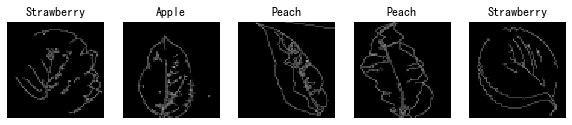

In [37]:
fig, ax = plt.subplots(1, 5, figsize=(10, 10))
for i in range(5):
    ax[i].set_axis_off()
    ax[i].imshow(X[i])
    ax[i].set_title(labels[np.argmax(Y[i])])

In [38]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=1)
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((1861, 64, 64, 3), (207, 64, 64, 3), (1861, 5), (207, 5))

In [39]:
INPUT_SHAPE = (64, 64, 3)
def build_model():
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', 
                     input_shape=INPUT_SHAPE))
    model.add(BatchNormalization(axis=1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization(axis=1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization(axis=1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))

    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    model.summary()
    return model

In [40]:
save_model=tf.keras.models.load_model('model/V4_0.956858%.h5')

In [41]:
BATCH_SIZE = 32
EPOCHS = 25
model = build_model()
#annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
#checkpoint = ModelCheckpoint('model/V4_0.99%.h5', verbose=1, save_best_only=True)
#callbacks=[annealer, checkpoint],
custom = model.fit(X_train,Y_train,epochs=EPOCHS,batch_size=BATCH_SIZE,validation_split = 0.1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
batch_normalization_3 (Batch (None, 62, 62, 32)        248       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 29, 29, 64)        116       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)       

In [42]:
#test
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

7/7 [==============================] - 0s 32ms/step - loss: 0.4179 - accuracy: 0.8792
Final Loss: 0.41793039441108704, Final Accuracy: 0.8792270421981812


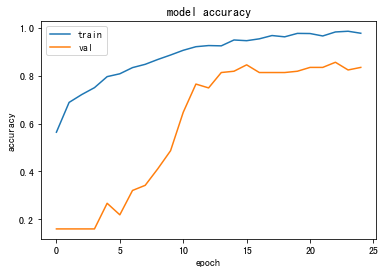

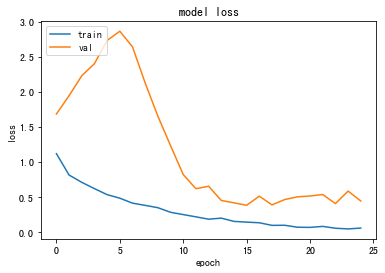

In [43]:
plt.plot(custom.history['accuracy'])
plt.plot(custom.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(custom.history['loss'])
plt.plot(custom.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Text(0.5, 64.15999999999998, 'Predicted')

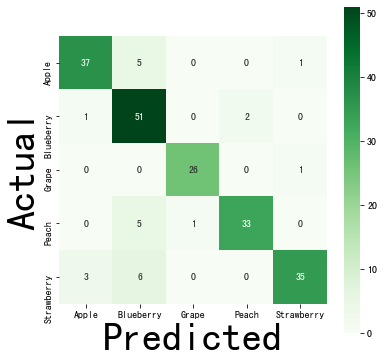

In [44]:
Y_pred = model.predict(X_val) # model.predict(X_test)
Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)
cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(6, 6))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=labels, yticklabels=labels)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

In [45]:
print(classification_report(Y_true, Y_pred))
print(f1_score(Y_true, Y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88        43
           1       0.76      0.94      0.84        54
           2       0.96      0.96      0.96        27
           3       0.94      0.85      0.89        39
           4       0.95      0.80      0.86        44

    accuracy                           0.88       207
   macro avg       0.90      0.88      0.89       207
weighted avg       0.89      0.88      0.88       207

0.8802419742984813


In [49]:
model.save('model/V4_0.88%_canny.h5')
#model.save_weights('model/V4_model_weights_0.90%.h5')
#model=tf.keras.models.load_model('model/V4_model_0.89%.h5')

In [47]:
from tensorflow.keras.preprocessing import image
for i in range(200):
    test=X_test[i]
    test=image.img_to_array(test)
    test=test.reshape((-1,64,64,3))
    predictions = model.predict(test)
    #print(predictions)
    print("預測結果: "+ labels2[np.argmax(predictions)])
    print("真實結果: " + labels2[np.argmax(y_test[i])])
    #print(y_test[i])
    #print(predictions)
    print("-----------")

預測結果: Blueberry
真實結果: Apple
-----------
預測結果: Blueberry
真實結果: Apple
-----------
預測結果: Grape
真實結果: Apple
-----------
預測結果: Apple
真實結果: Apple
-----------
預測結果: Apple
真實結果: Apple
-----------
預測結果: Apple
真實結果: Apple
-----------
預測結果: Blueberry
真實結果: Apple
-----------
預測結果: Blueberry
真實結果: Apple
-----------
預測結果: Blueberry
真實結果: Apple
-----------
預測結果: Apple
真實結果: Apple
-----------
預測結果: Apple
真實結果: Apple
-----------
預測結果: Apple
真實結果: Apple
-----------
預測結果: Blueberry
真實結果: Apple
-----------
預測結果: Blueberry
真實結果: Apple
-----------
預測結果: Blueberry
真實結果: Apple
-----------
預測結果: Apple
真實結果: Apple
-----------
預測結果: Blueberry
真實結果: Apple
-----------
預測結果: Blueberry
真實結果: Apple
-----------
預測結果: Grape
真實結果: Apple
-----------
預測結果: Blueberry
真實結果: Apple
-----------
預測結果: Peach
真實結果: Apple
-----------
預測結果: Blueberry
真實結果: Apple
-----------
預測結果: Grape
真實結果: Apple
-----------
預測結果: Blueberry
真實結果: Apple
-----------
預測結果: Grape
真實結果: Apple
-----------
預測結果: Blueberry
真實結果: Apple
-----------
預測結果: Bl

In [48]:
16

16